In [29]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [30]:
#file     = uproot.open('./20230523/laser000010.bin.root')
#file     = uproot.open('./20230525/dark_tr100000013.bin.root')
file     = uproot.open('/Users/ishiwata/grams/data/20230529/laser_tr60_bl129_1000ns_delay240ns_CFD000025.bin.root')
#file     = uproot.open('./20230530/laser_tr60_bl129_1000ns_delay240ns_CFD000027.bin.root')
#file     = uproot.open('./20230530/laser_tr60_bl129_1000ns_delay240ns_CFD_qdcfilter200ns000028.bin.root')
#file     = uproot.open('./20230530/laser_tr60_bl129_1000ns_delay240ns_CFD_qdcfilter100ns000029.bin.root')



header   = file['header']
tree     = file['tree']

QDC      = tree.arrays(['qdc'], library='numpy')['qdc']
waveform = tree.arrays(['waveform'], library='numpy')['waveform']
timebin_width = header.arrays(['timebin_width'], library='numpy')['timebin_width'] #ns
wave_num = tree.arrays(['wave_num'], library='numpy')['wave_num'][0]
time_array    = np.arange(wave_num) * timebin_width #* ns2us


In [5]:
#異常なdataを排除
numlist=[]
bad_numlist=[]
n=0
for i in range(20000):
    p2p=np.max(waveform[i])-np.min(waveform[i])
    if p2p < 3000:
        numlist.append(n)
    else:
        bad_numlist.append(n)
    n=n+1
print(len(numlist))
print(len(bad_numlist))








18676
1324


In [32]:

def mplot(n,init):
    plt.figure(figsize=(15,15))
    for i in range(n):
        plt.subplot(int(n/2),3,i+1)
        plt.plot(time_array,waveform[i+init])
        plt.title(f"waveform[{i+init}]")
        plt.xlabel("time[ns]")
        plt.ylabel("ADC[digit]")

def calc_peak(waveform,factor):
    X=waveform
    N =len(X)      #データ長
    fs=1e+9          #サンプリング周波数
    dt =1/fs       # サンプリング間隔
    t = np.arange(0.0, N*dt, dt) #時間軸
    freq = np.linspace(0, fs,N) #周波数軸
    fn=1/dt/2     #ナイキスト周波数
    F=np.fft.fft(X)/(N/2)
    F[(freq>fn)]=0 #ナイキスト周波数以降をカット
    X_0=np.abs(F)
    threshold=np.amax(X_0)*factor
    peak_index=np.where(X_0 > threshold) #顕著なピークを検出
    print(f"peak_index={peak_index}")
    peak_freq=[]
    for n in peak_index:
        peak_freq.append(freq[n])
    print(f"peak_freq={peak_freq}")
    plt.plot(freq,X_0)
    plt.hlines(threshold,0,fs,colors="r")
    return peak_freq

#除去したいwaveform,peak周波数
def rm_peak(waveform,peak_freq):
    X=waveform
    N =len(X)      #データ長
    fs=1e+9          #サンプリング周波数
    dt =1/fs       # サンプリング間隔
    t = np.arange(0.0, N*dt, dt) #時間軸
    freq = np.linspace(0, fs,N) #周波数軸
    fn=1/dt/2     #ナイキスト周波数
    F=np.fft.fft(X)/(N/2)
    F[(freq>fn)]=0 #ナイキスト周波数以降をカット
    X_0=np.abs(F) #FFTした波形(横軸周波数)
    #peak周波数を除去
    print(peak_freq)
    for hz in peak_freq:
        F[(freq==hz)]=0
    X_1=np.abs(F) #trendを除去した波形(横軸周波数)
    X_2=np.real(np.fft.ifft(F))*N #trendを除去した波形(横軸時間[ns]) waveform
    plt.figure(figsize=(15,8))

    plt.subplot(2,2,1)
    plt.plot(time_array,waveform)
    plt.xlabel("time[ns]")
    plt.ylabel("ADC[digit]")
    plt.title("waveform")

    plt.subplot(2,2,2)
    plt.plot(freq,X_0)
    plt.xlabel("freqency[Hz]")
    plt.ylabel("Amp") 
    plt.title("fft-waveform freq-Amp plot")


    plt.subplot(2,2,3)
    plt.plot(freq,X_1)
    plt.xlabel("freqency[Hz]")
    plt.ylabel("Amp")
    plt.title("removed peak_freq freq-Amp plot")


    plt.subplot(2,2,4)
    plt.plot(time_array,X_2)
    plt.xlabel("time[ns]")
    plt.ylabel("ADC[digit]")
    plt.title("ifft-wavefomr time-ADC plot")
    return X_2

def qdc_plot(num,delta):
    qdc=[]
    for i in range(num):
        peak_index=np.amax(waveform[i])
        summed_waveform=sum(waveform[i][peak_index:peak_index+delta])
        qdc.append(summed_waveform)
    qdc=np.array(qdc)
    xmin=np.min(qdc)
    xmax=np.max(qdc)
    plt.figure(figsize=(13,6))
    plt.hist(qdc,range=(xmin,xmax),bins=xmax-xmin)


peak_index=(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17, 250]),)
peak_freq=[array([0.00000000e+00, 1.00100100e+06, 2.00200200e+06, 3.00300300e+06,
       4.00400400e+06, 5.00500501e+06, 6.00600601e+06, 7.00700701e+06,
       8.00800801e+06, 9.00900901e+06, 1.00100100e+07, 1.10110110e+07,
       1.20120120e+07, 1.30130130e+07, 1.40140140e+07, 1.50150150e+07,
       1.60160160e+07, 1.70170170e+07, 2.50250250e+08])]


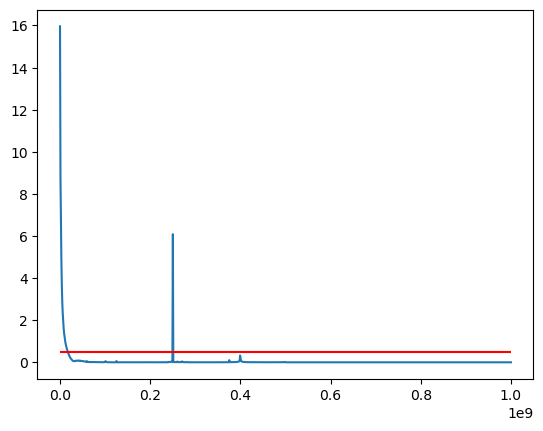

In [33]:
#平均波形の作成
sum_wave=np.zeros(wave_num)
for i in numlist:
    sum_wave=sum_wave+waveform[i]
ave_wave=sum_wave/len(numlist)

peak_freq=calc_peak(ave_wave,0.03)

[250250250.25025025]
[250250250.25025025]


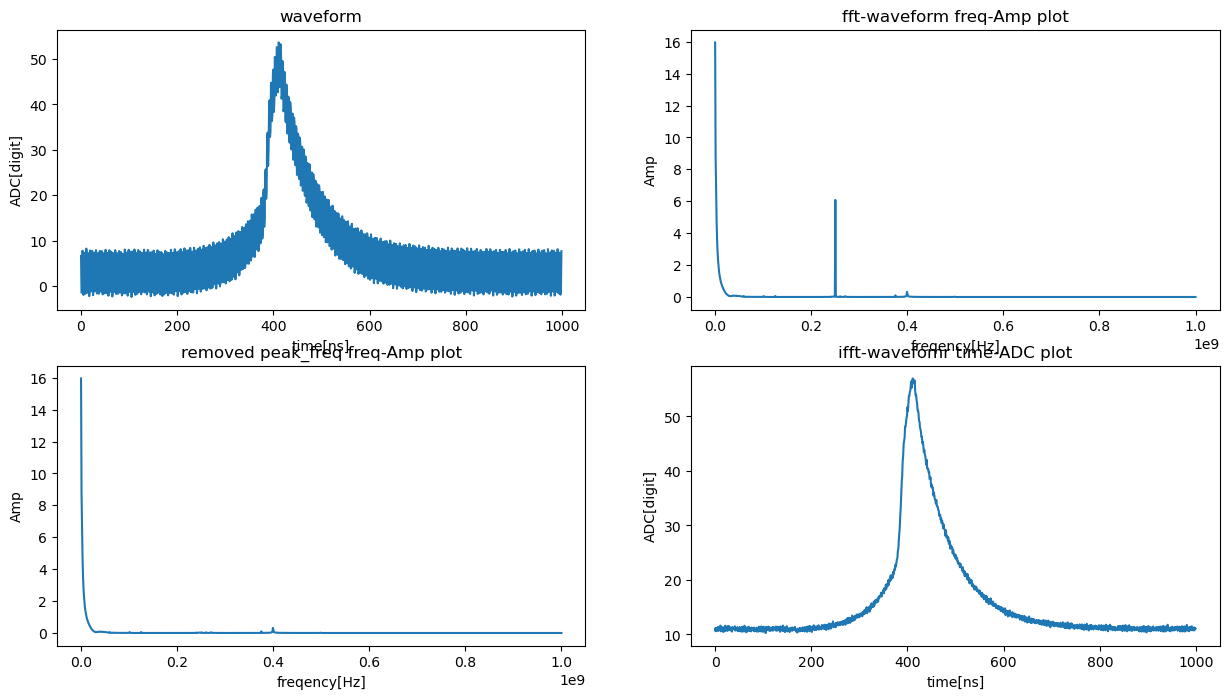

In [45]:

#######################
#peak_freqは適切に設定
#######################
peak_freq=np.array([peak_freq[0][-1]]).tolist()
print(peak_freq)
rm_peak_wave=rm_peak(ave_wave,peak_freq)

In [46]:
#異なる時定数を持つ二つの指数関数でfit
def OneExpDecay(x, A, tau):
    return A * np.exp(-x/tau)
def TwoExpDecay(x, A, tau_f, B, tau_s, C):
    return A * np.exp( - x / tau_f ) + B * np.exp( - x / tau_s ) + C

peak_index=np.argmax(rm_peak_wave)
peak_time=time_array[peak_index]
fit_range_x=time_array[peak_index:peak_index+400]-peak_time

params, pcov = curve_fit(TwoExpDecay, fit_range_x, rm_peak_wave[peak_index:peak_index+400], p0 = (3,30, 100,100,150), bounds = (0,np.inf))  
tau_f, tau_s, A, B,C=params
ModelData_x = np.arange(0, len(fit_range_x), 0.01)
ModelData_y = OneExpDecay(ModelData_x, params[0], params[1])

print(f"tau_f={tau_f}")
print(f"tau_s={tau_s}")
print(f"A={A}")
print(f"B={B}")
print(f"C={C}")

tau_f=2.440552239613052
tau_s=16.732598645093503
A=44.6032598360057
B=73.07094521524648
C=11.036839498292784


'\nplt.subplot(1,2,2)\nplt.plot(time_array,rm_peak_wave,label="average_data_10000_fft")\nplt.plot(time_array[peak_index:peak_index+400],TwoExpDecay(time_array[peak_index:peak_index+400]-peak_time,tau_f,tau_s,A,B,C),color="r",label="TwoExpModel+const(151.30)")\nplt.plot(time_array[peak_index:peak_index+400],OneExpDecay(time_array[peak_index:peak_index+400]-peak_time,tau_f,A),color="g",label="fast_decay tau=17.04[ns]")\nplt.plot(time_array[peak_index:peak_index+400],OneExpDecay(time_array[peak_index:peak_index+400]-peak_time,tau_s,B),color="pink",label="slow_decay tau=72.88[ns]")\n#plt.ylim(100,1000)\nplt.yscale("log")\nplt.xlabel("Time[ns]")\nplt.ylabel("ADC[digit]")\nplt.legend()\n'

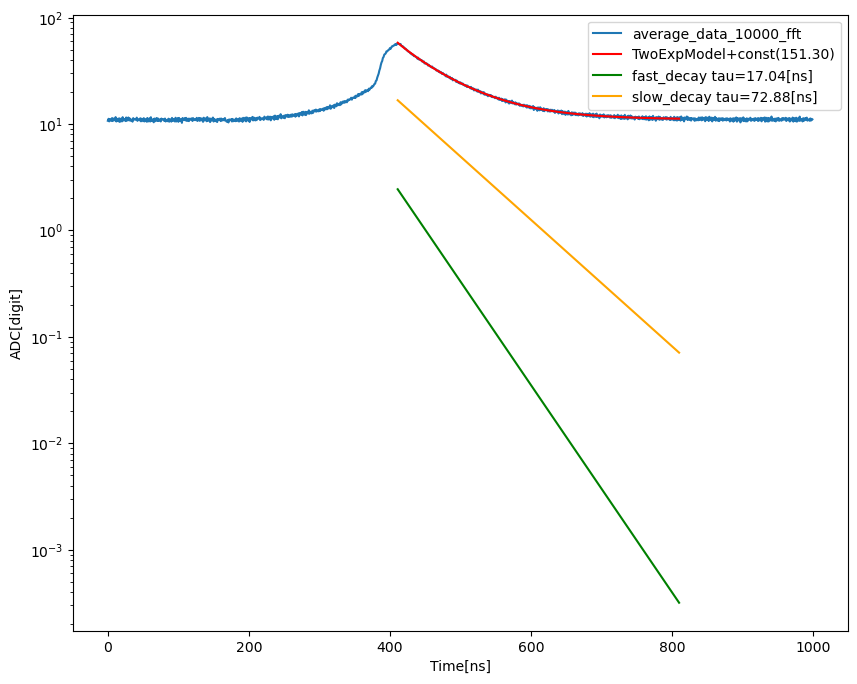

In [48]:
plt.figure(figsize=(10,8))

#plt.subplot(1,2,1)
plt.plot(time_array,rm_peak_wave,label="average_data_10000_fft")
plt.plot(time_array[peak_index:peak_index+400],TwoExpDecay(time_array[peak_index:peak_index+400]-peak_time,tau_f,tau_s,A,B,C),color="r",label="TwoExpModel+const(151.30)")
plt.plot(time_array[peak_index:peak_index+400],OneExpDecay(time_array[peak_index:peak_index+400]-peak_time,tau_f,A),color="g",label="fast_decay tau=17.04[ns]")
plt.plot(time_array[peak_index:peak_index+400],OneExpDecay(time_array[peak_index:peak_index+400]-peak_time,tau_s,B),color="orange",label="slow_decay tau=72.88[ns]")
#plt.plot(time_array[peak_index:peak_index+400],)
plt.yscale("log")
plt.xlabel("Time[ns]")
plt.ylabel("ADC[digit]")
plt.legend()
"""
plt.subplot(1,2,2)
plt.plot(time_array,rm_peak_wave,label="average_data_10000_fft")
plt.plot(time_array[peak_index:peak_index+400],TwoExpDecay(time_array[peak_index:peak_index+400]-peak_time,tau_f,tau_s,A,B,C),color="r",label="TwoExpModel+const(151.30)")
plt.plot(time_array[peak_index:peak_index+400],OneExpDecay(time_array[peak_index:peak_index+400]-peak_time,tau_f,A),color="g",label="fast_decay tau=17.04[ns]")
plt.plot(time_array[peak_index:peak_index+400],OneExpDecay(time_array[peak_index:peak_index+400]-peak_time,tau_s,B),color="pink",label="slow_decay tau=72.88[ns]")
#plt.ylim(100,1000)
plt.yscale("log")
plt.xlabel("Time[ns]")
plt.ylabel("ADC[digit]")
plt.legend()
"""

In [73]:
print(X)

[[0.90289942 0.1267817  0.89003027 ... 0.21023623 0.02877964 0.18527222]
 [0.87557027 0.34670819 0.84586822 ... 0.80932344 0.06322637 0.79622685]
 [0.55801692 0.59794468 0.13249504 ... 0.44994576 0.47762885 0.51394856]
 ...
 [0.84811592 0.61445637 0.04034733 ... 0.83747912 0.99657611 0.00466433]
 [0.45809421 0.76576835 0.40611916 ... 0.19017187 0.57993691 0.9338074 ]
 [0.99916062 0.76416141 0.00566675 ... 0.74034193 0.06396102 0.80569273]]


In [75]:
from sklearn.svm import SVC
import numpy as np

# データセットの準備
# Xは特徴ベクトルの行列、yは対応するラベルのベクトルとします
X = np.random.rand(10, 200)  # 10個の一次元配列
y = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])  # 分類ラベル

# SVMモデルの作成と学習
clf = SVC()
clf.fit(X, y)

# 分類するデータの作成
test_data = np.random.rand(2, 200)  # 2個の一次元配列

# データの分類
predictions = clf.predict(test_data)

# 分類結果の表示
for i, pred in enumerate(predictions):
    print(f"Test data {i+1} is predicted as class {pred}")


Test data 1 is predicted as class 0
Test data 2 is predicted as class 1


In [80]:
a=np.array([waveform[10],waveform[11]])

In [83]:
print(a.shape)
print(a.ndim)

(2, 200)
2


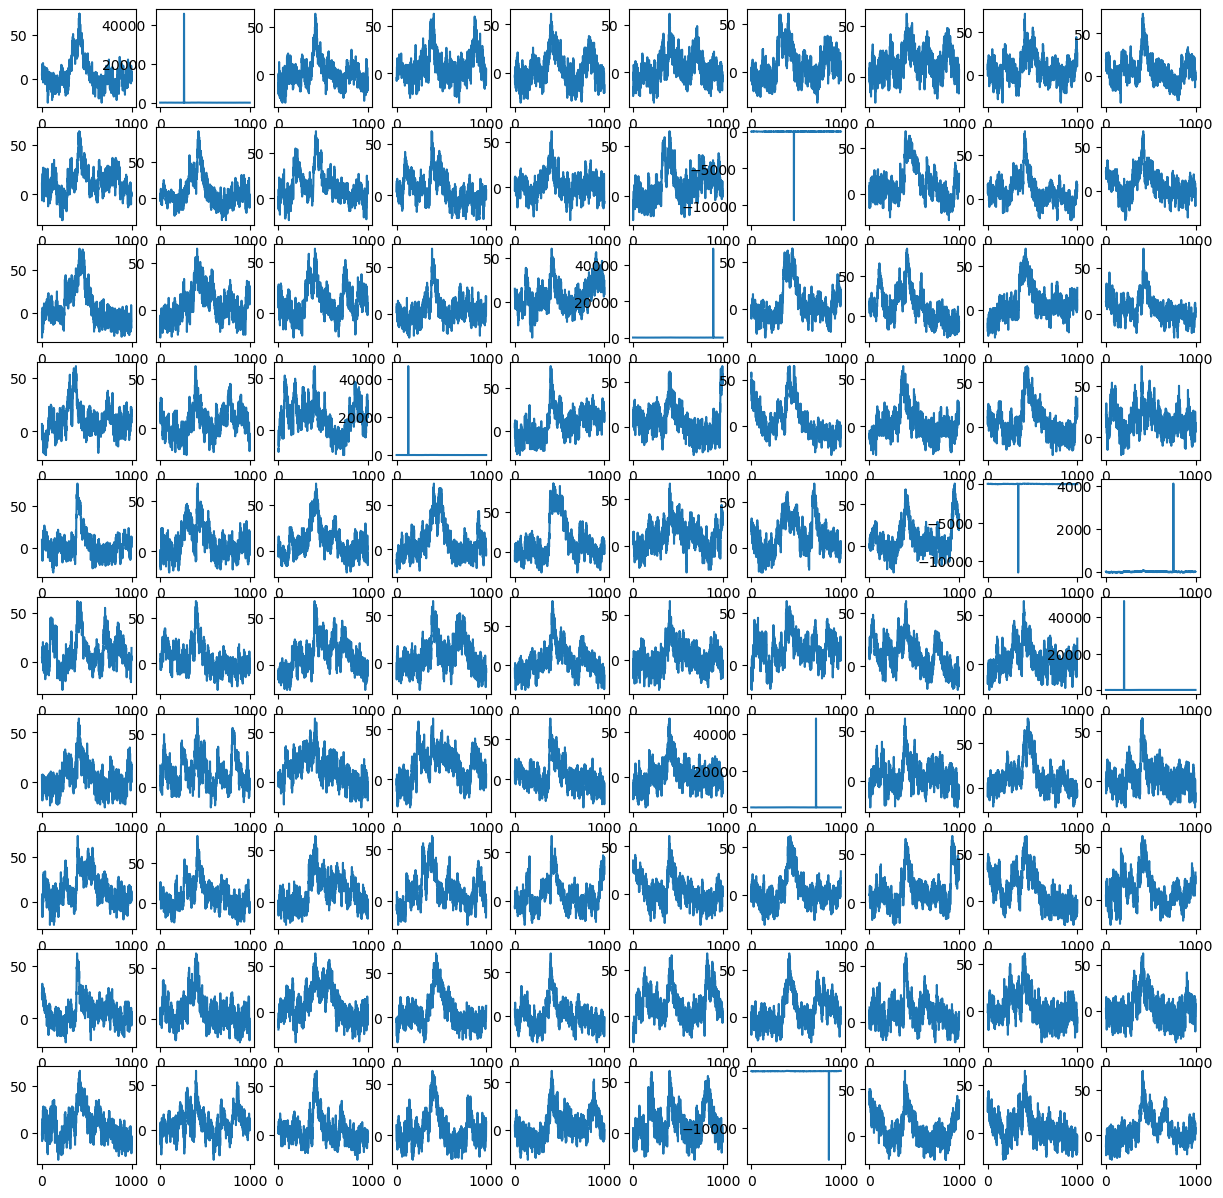

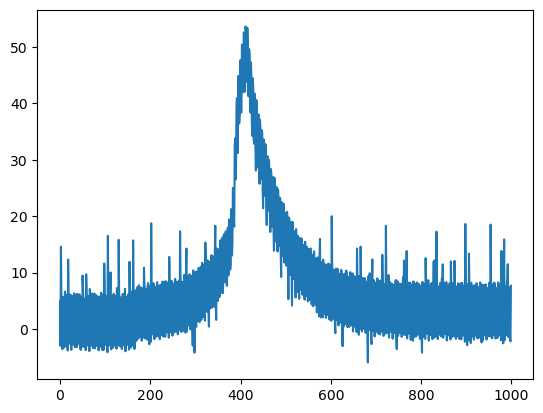

In [8]:
plt.plot(time_array,ave_wave)
plt.x